# Seurat - Guided Clustering Tutorial
元URL: https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html

(最終更新 2020/12/25)

## Setup the Seurat Object

- このチュートリアルでは、10X Genomicsから自由に入手できる末梢血単核細胞（PBMC, 2,700 cells）のデータセットを解析します。
- `Read10X`関数は、10Xから cellranger pipeline の出力を読み込んで、UMIマトリックスを返します。
- このUMIマトリックスを使用して、Seuratオブジェクトを作成します。このオブジェクトは、scRNA-seqデータ（UMIマトリックス）と解析（PCAやクラスタリング結果）の両方を格納するコンテナとしての役割を果たします。

以下のコマンドはR上で実行します。

In [1]:
# ライブラリ読み込み
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## バージョンの確認
`sessionInfo()`コマンドを使って今読み込んでいるライブラリのバージョンを確認します。エラーの多くは古いバージョンなどを使っていることに起因しますので、常にバージョンを確認する癖をつけておきましょう。ここでは R version 4.0.3, Seuratのバージョンは3.2.2 です。

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.1   Seurat_3.2.2.9001 dplyr_1.0.2      

loaded via a namespace (and not attached):
  [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
  [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
  [7] sctransform_0.

## データ読み込み
PBMCのデータ2700細胞を読み込みます。ここでは10Xで生成されたデータをそのまま読み込めるRead10Xコマンドを利用しています。
入力データとして、filtered_gene_bc_matrices 内の hg19 フォルダを指定します。

生成されたSeuratオブジェクトを確認すると、2700細胞 × 13714遺伝子の行列データになっていることがわかります。

In [3]:
# Load the PBMC dataset (cellrangerのraw dataを読み込み、UMIの行列に変換)
pbmc.data <- Read10X(data.dir = "./filtered_gene_bc_matrices/hg19/")

# Initialize the Seurat object with the raw (non-normalized data).
# min.cells, min.features はそれぞれ最低発現細胞数、遺伝子数
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

カウント行列の中身を閲覧するには、`pbmc[["RNA"]]@counts` または `pbmc.data` と指定します。
この２つはいずれもUMI値ですが遺伝子の並び順は異なるようです。

UMI値を表示した時のドットは発現量が0であることを表します。sparse-matrix representationによってメモリ使用量を抑えています。

In [4]:
# 最初の20細胞中の冒頭10遺伝子についてUMI値を表示
pbmc[["RNA"]]@counts[1:10,1:20]
# pbmc.data[1:10,1:20]  でも同じ（並び順は異なる）

   [[ suppressing 20 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



10 x 20 sparse Matrix of class "dgCMatrix"
                                                     
AL627309.1    . . . . . . . . . . . . . . . . . . . .
AP006222.2    . . . . . . . . . . . . . . . . . . . .
RP11-206L10.2 . . . . . . . . . . . . . . . . . . . .
RP11-206L10.9 . . . . . . . . . . . . . . . . . . . .
LINC00115     . . . . . . . . . . . . . . . . . . . .
NOC2L         . . . . . . . . . . . 1 . . . . . . . .
KLHL17        . . . . . . . . . . . . . . . . . . . .
PLEKHN1       . . . . . . . . . . . . . . . . . . . .
RP11-54O7.17  . . . . . . . . . . . . . . . . . . . .
HES4          . . . . . . . . . . . . . . . . . . 1 .

In [5]:
# 最初の30細胞における特定の遺伝子を表示
# pbmc.data["CD3D", 1:30]  # 1遺伝子の場合
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]  # 複数遺伝子を指定する場合

   [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

## 前処理

- 以下のステップは、Seuratでの scRNA-seq データの標準的な前処理ワークフロー（品質評価(QC)、細胞フィルタリング、データ正規化・スケーリング、高変動遺伝子）を行います。
- Seuratでは以下のような基準に基づいてQC・細胞フィルタリングをします。

    - 各細胞で検出されたユニークな遺伝子の数。
        
        - 低品質の細胞や空の液滴は、多くの場合、非常に少ない遺伝子数になります。
        - 細胞のダブレットまたはマルチプレットは、異常に高い遺伝子数を示すことがあります。
    - 細胞内で検出された総分子数（ユニークな遺伝子と強く相関する）
    - ミトコンドリアゲノムにマップするリードの割合
    
        - 低品質/死細胞は、しばしば高いミトコンドリアの値となります。
        - ミトコンドリアの QC メトリクスは `PercentageFeatureSet` 関数を使用して計算します。

- ここでは遺伝子名が"MT-"で始まる遺伝子をミトコンドリアRNAとみなしています。
- 以下ではその値を "percent.mt" という列名でpbmcオブジェクトに新たに追加します。

In [6]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC 
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

QCの値はpbmc@meta.dataに格納されます。
**percent.mt**の他、**nCount**: 総UMI数, **nFeature**: 発現遺伝子数、の値が格納されています。

In [7]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


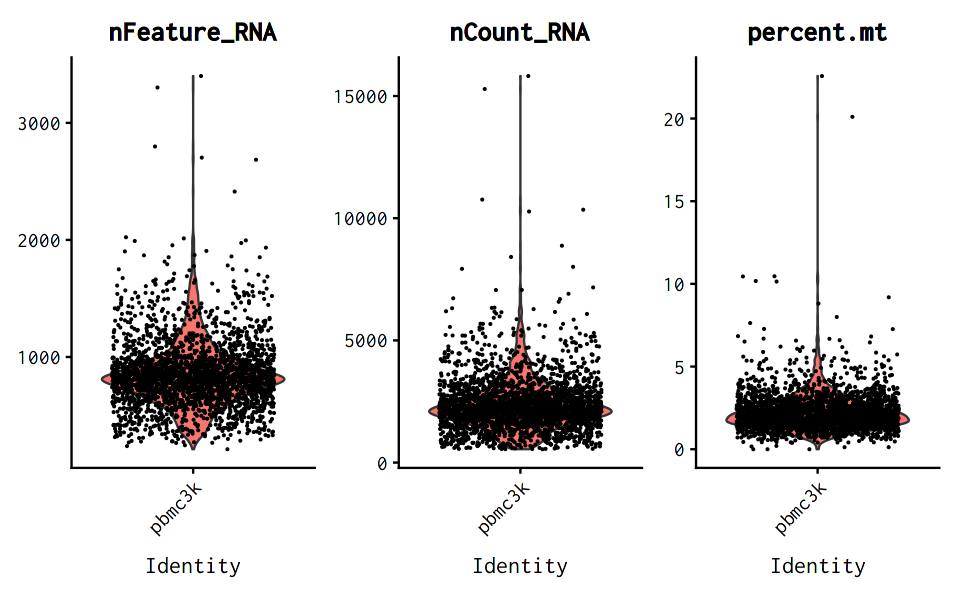

In [8]:
# Visualize QC metrics as a violin plot
options(repr.plot.width = 8, repr.plot.height = 5) # Jupyter上での図のサイズを変更
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0.1)

以下では二種類のQC値を散布図としてプロットしています。
これにより、「UMI値に対して発現遺伝子数が少なすぎる」というような細胞を検出することができます。

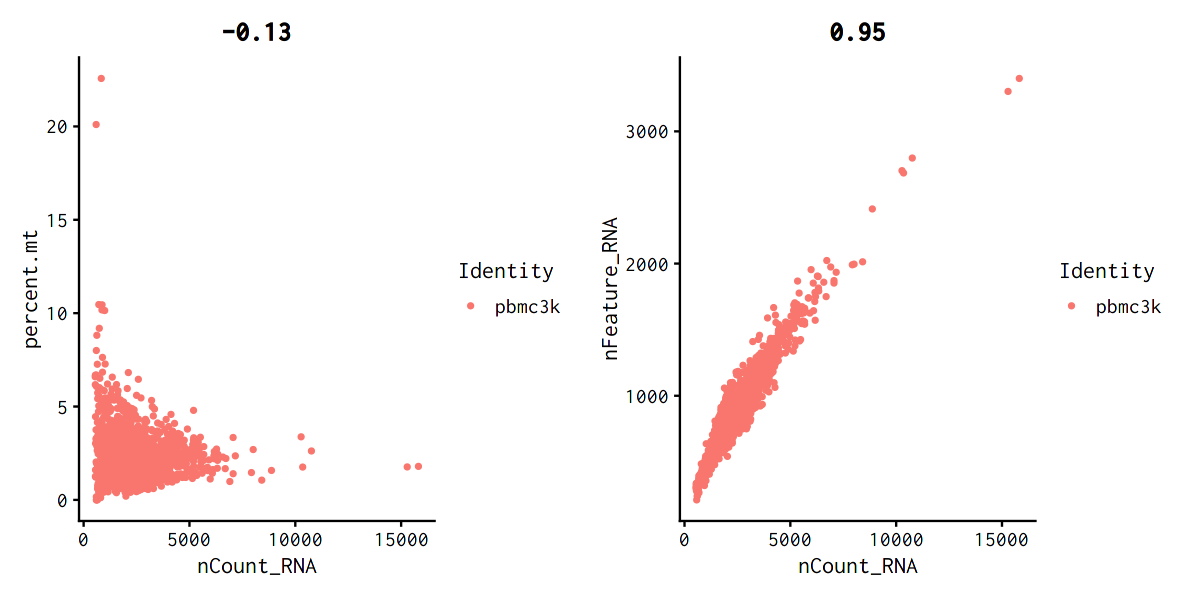

In [9]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

以下のコマンドでは実際におかしな値を持つ細胞をフィルタしています。

**subset**　コマンドは、**=** 以後の条件を満たす細胞だけを返します。
'条件1 & 条件2' は「条件１かつ条件２」を示します。

In [10]:
### We filter cells that have unique feature counts over 2,500 or less than 200
### and cells that have > 5% mitochondrial counts
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## 正規化

デフォルトでは"**LogNormalize**"を採用しており、細胞ごとの総UMI数が10,000になるように正規化し、結果をlog変換します。正規化された値はpbmc[["RNA"]@dataに格納されます。

In [11]:
#pbmc <- NormalizeData(pbmc)
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000) #でも同じ


（作成者注：scRNA-seqのためのツールでは、**正規化後の行列**を要求するものと**正規化前の行列**を要求するものがありますので、自分が今どのデータを使っているかは常に意識しておく必要があります。Seuratは対数変換された正規化行列を以降の解析で用います。）

### Highly variable genes (HVGs) の抽出 （特徴選択）

- クラスタリング解析においては、細胞間で「発現量に対して細胞ごとの変動（分散）が大きい遺伝子 (**Highly variable genes**)」 が基本的な興味の対象となります。
- Seurat3では`FindVariableFeatures`関数で実装されています。ここでは、特に分散の大きい 2,000遺伝子のみを抽出して残りは削除するという操作を行います。

（作成者注：これは前述の細胞フィルタリングとは異なり、主に計算量を削減するための操作です。従ってマシンパワーが許すならこの操作を行わなくても構いません（その方が望ましいと思います））。

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


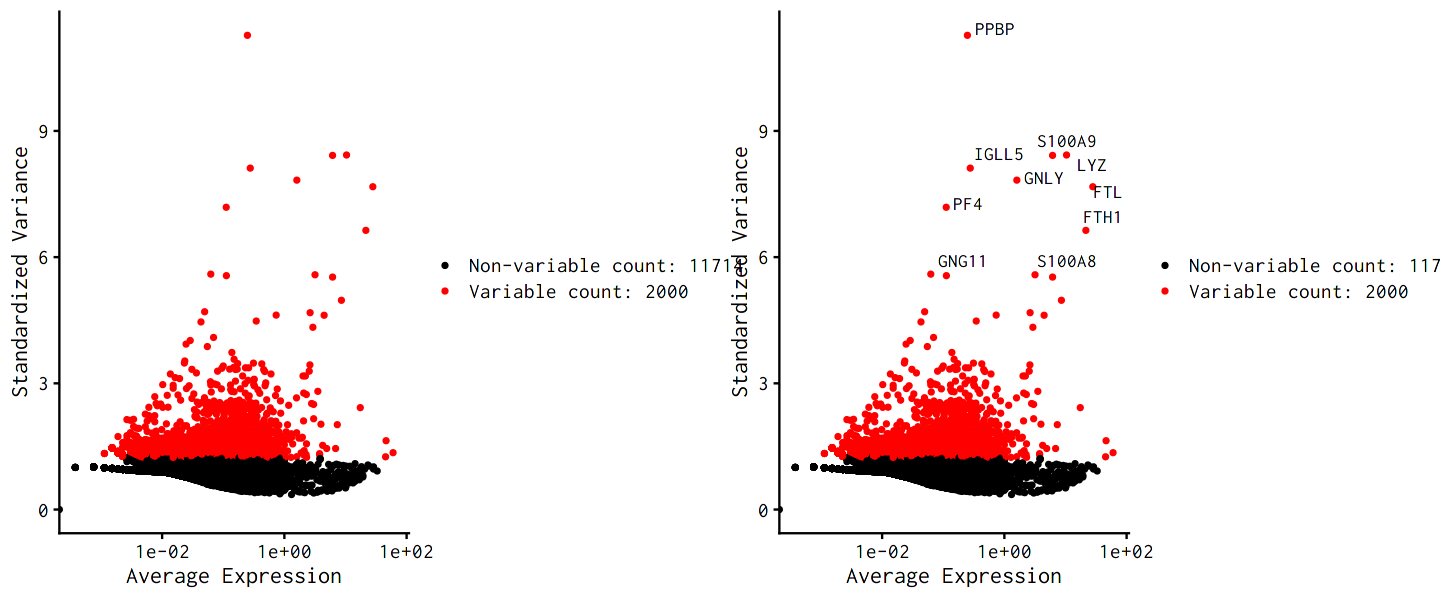

In [12]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# 上位10個のHVGsをtop10に格納
top10 <- head(VariableFeatures(pbmc), 10)

options(repr.plot.width = 12, repr.plot.height = 5)
# HVGsを赤色として「発現量ー分散」の散布図をプロット
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
#plot1 + plot2   # エラーになるのでCombinePlotsを使う
CombinePlots(plots = list(plot1, plot2))

## データスケーリング

（作成者注：Seuratでは正規化 (normalization)と線形変換 (scaling)は別物として定義している。）

`ScaleData`関数により、全細胞に対し、発現量の平均が0、分散が1になるようにスケーリングします（Zスコア的）。結果は`pbmc[["RNA"]]@scale.data`に格納されます。


In [13]:
all.genes <- rownames(pbmc)

# scaled by all genes
pbmc <- ScaleData(pbmc, features = all.genes)

# Optional: scaled by highly variable (2,000) genes
# pbmc <- ScaleData(pbmc)   

Centering and scaling data matrix



## 次元削減
細胞を2次元上でプロットするため、遺伝子数の要素（次元）を持つ各細胞を2次元に**次元削減**します。
以下では**PCA, tSNE, UMAP**の三種類の次元削減法を試します。

（作成者注：次元削減とは簡単に言えば、３次元の風景の写真を撮ると、2次元の画像に変換されるということと考え方は同じです。
PCA（主成分分析）においては、３次元の風景の要素を可能な限り残したまま２次元にする、という作業が、適切な主成分（PC1, PC2）を選択していることになります。一方tSNE, UMAPは非線形変換となるので、変換後の要素の配置は変換前と異なるものになります。）

### PCA

In [14]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

### 意味のある次元数の推定
SeuratはtSNE, UMAPを用いて次元削減する際、上記のPCAで得られた主成分を用います。
その時、「元データの情報量を十分表現する次元（主成分）の数」を確かめるため、いくつかの方法を用います。

（作成者中：実際にはデフォルトの第10主成分まででよいことが多く、特に気にならなければこれらの工程はスキップしても問題ありません。）

In [15]:
# PC1からPC5までの上位・下位トップランク遺伝子を表示
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, SDPR, PF4, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, S100A8, NKG7, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


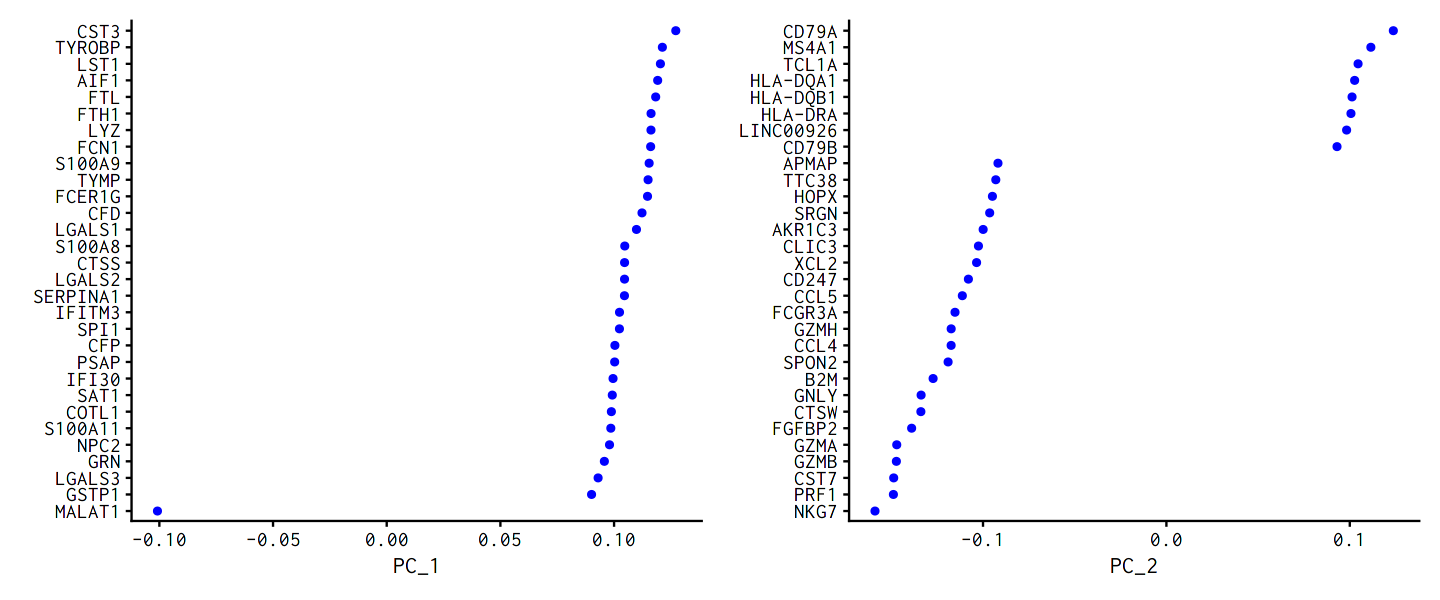

In [16]:
# PC1, PC2について同様に図で表示
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

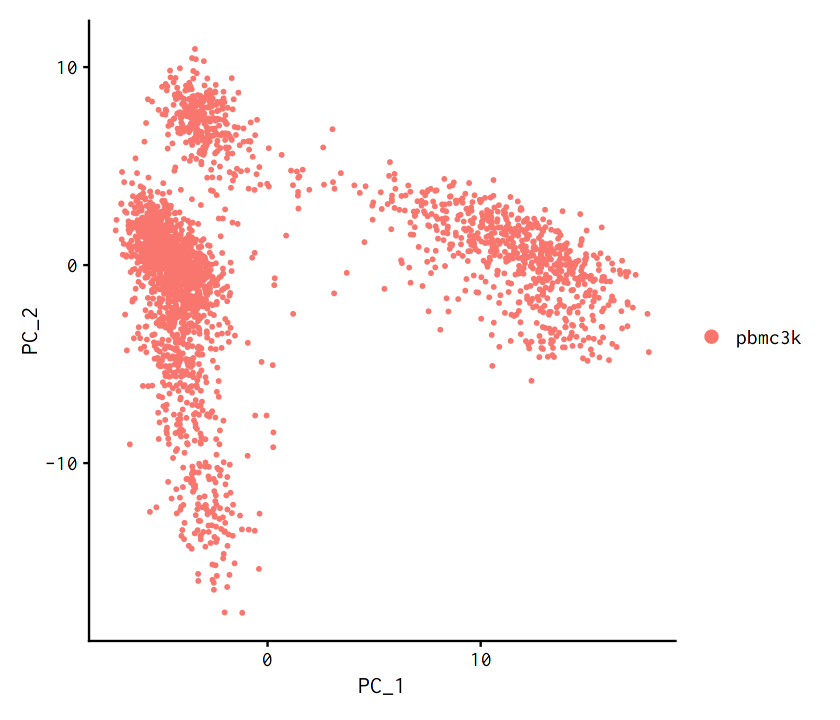

In [17]:
# PC1, PC2の散布図表示
options(repr.plot.width = 7, repr.plot.height = 6)
DimPlot(pbmc, reduction = "pca")

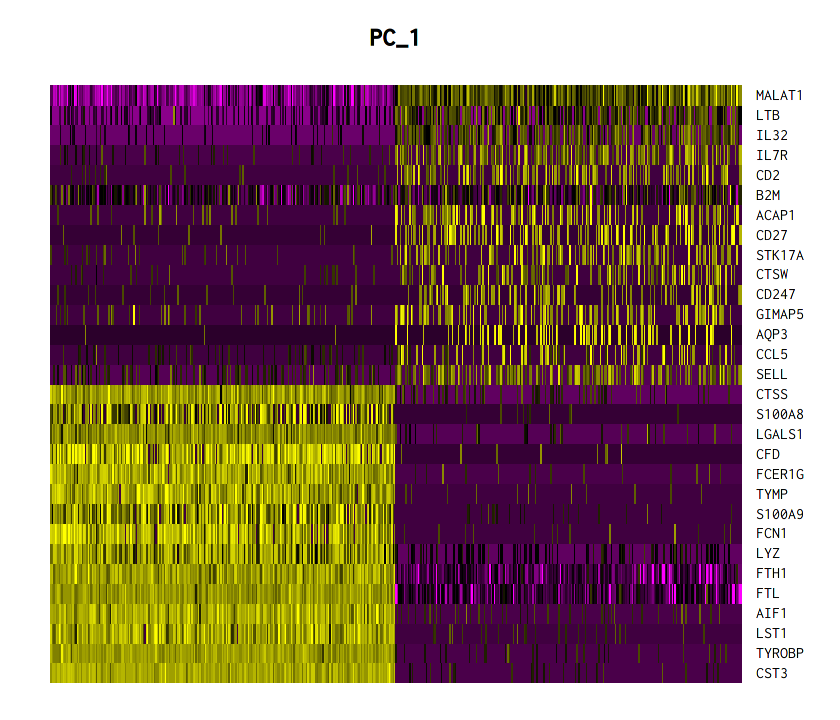

In [18]:
# PC1方向で正負トップランクの遺伝子について、ランダムに選ばれたそれぞれ500細胞での値を可視化
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

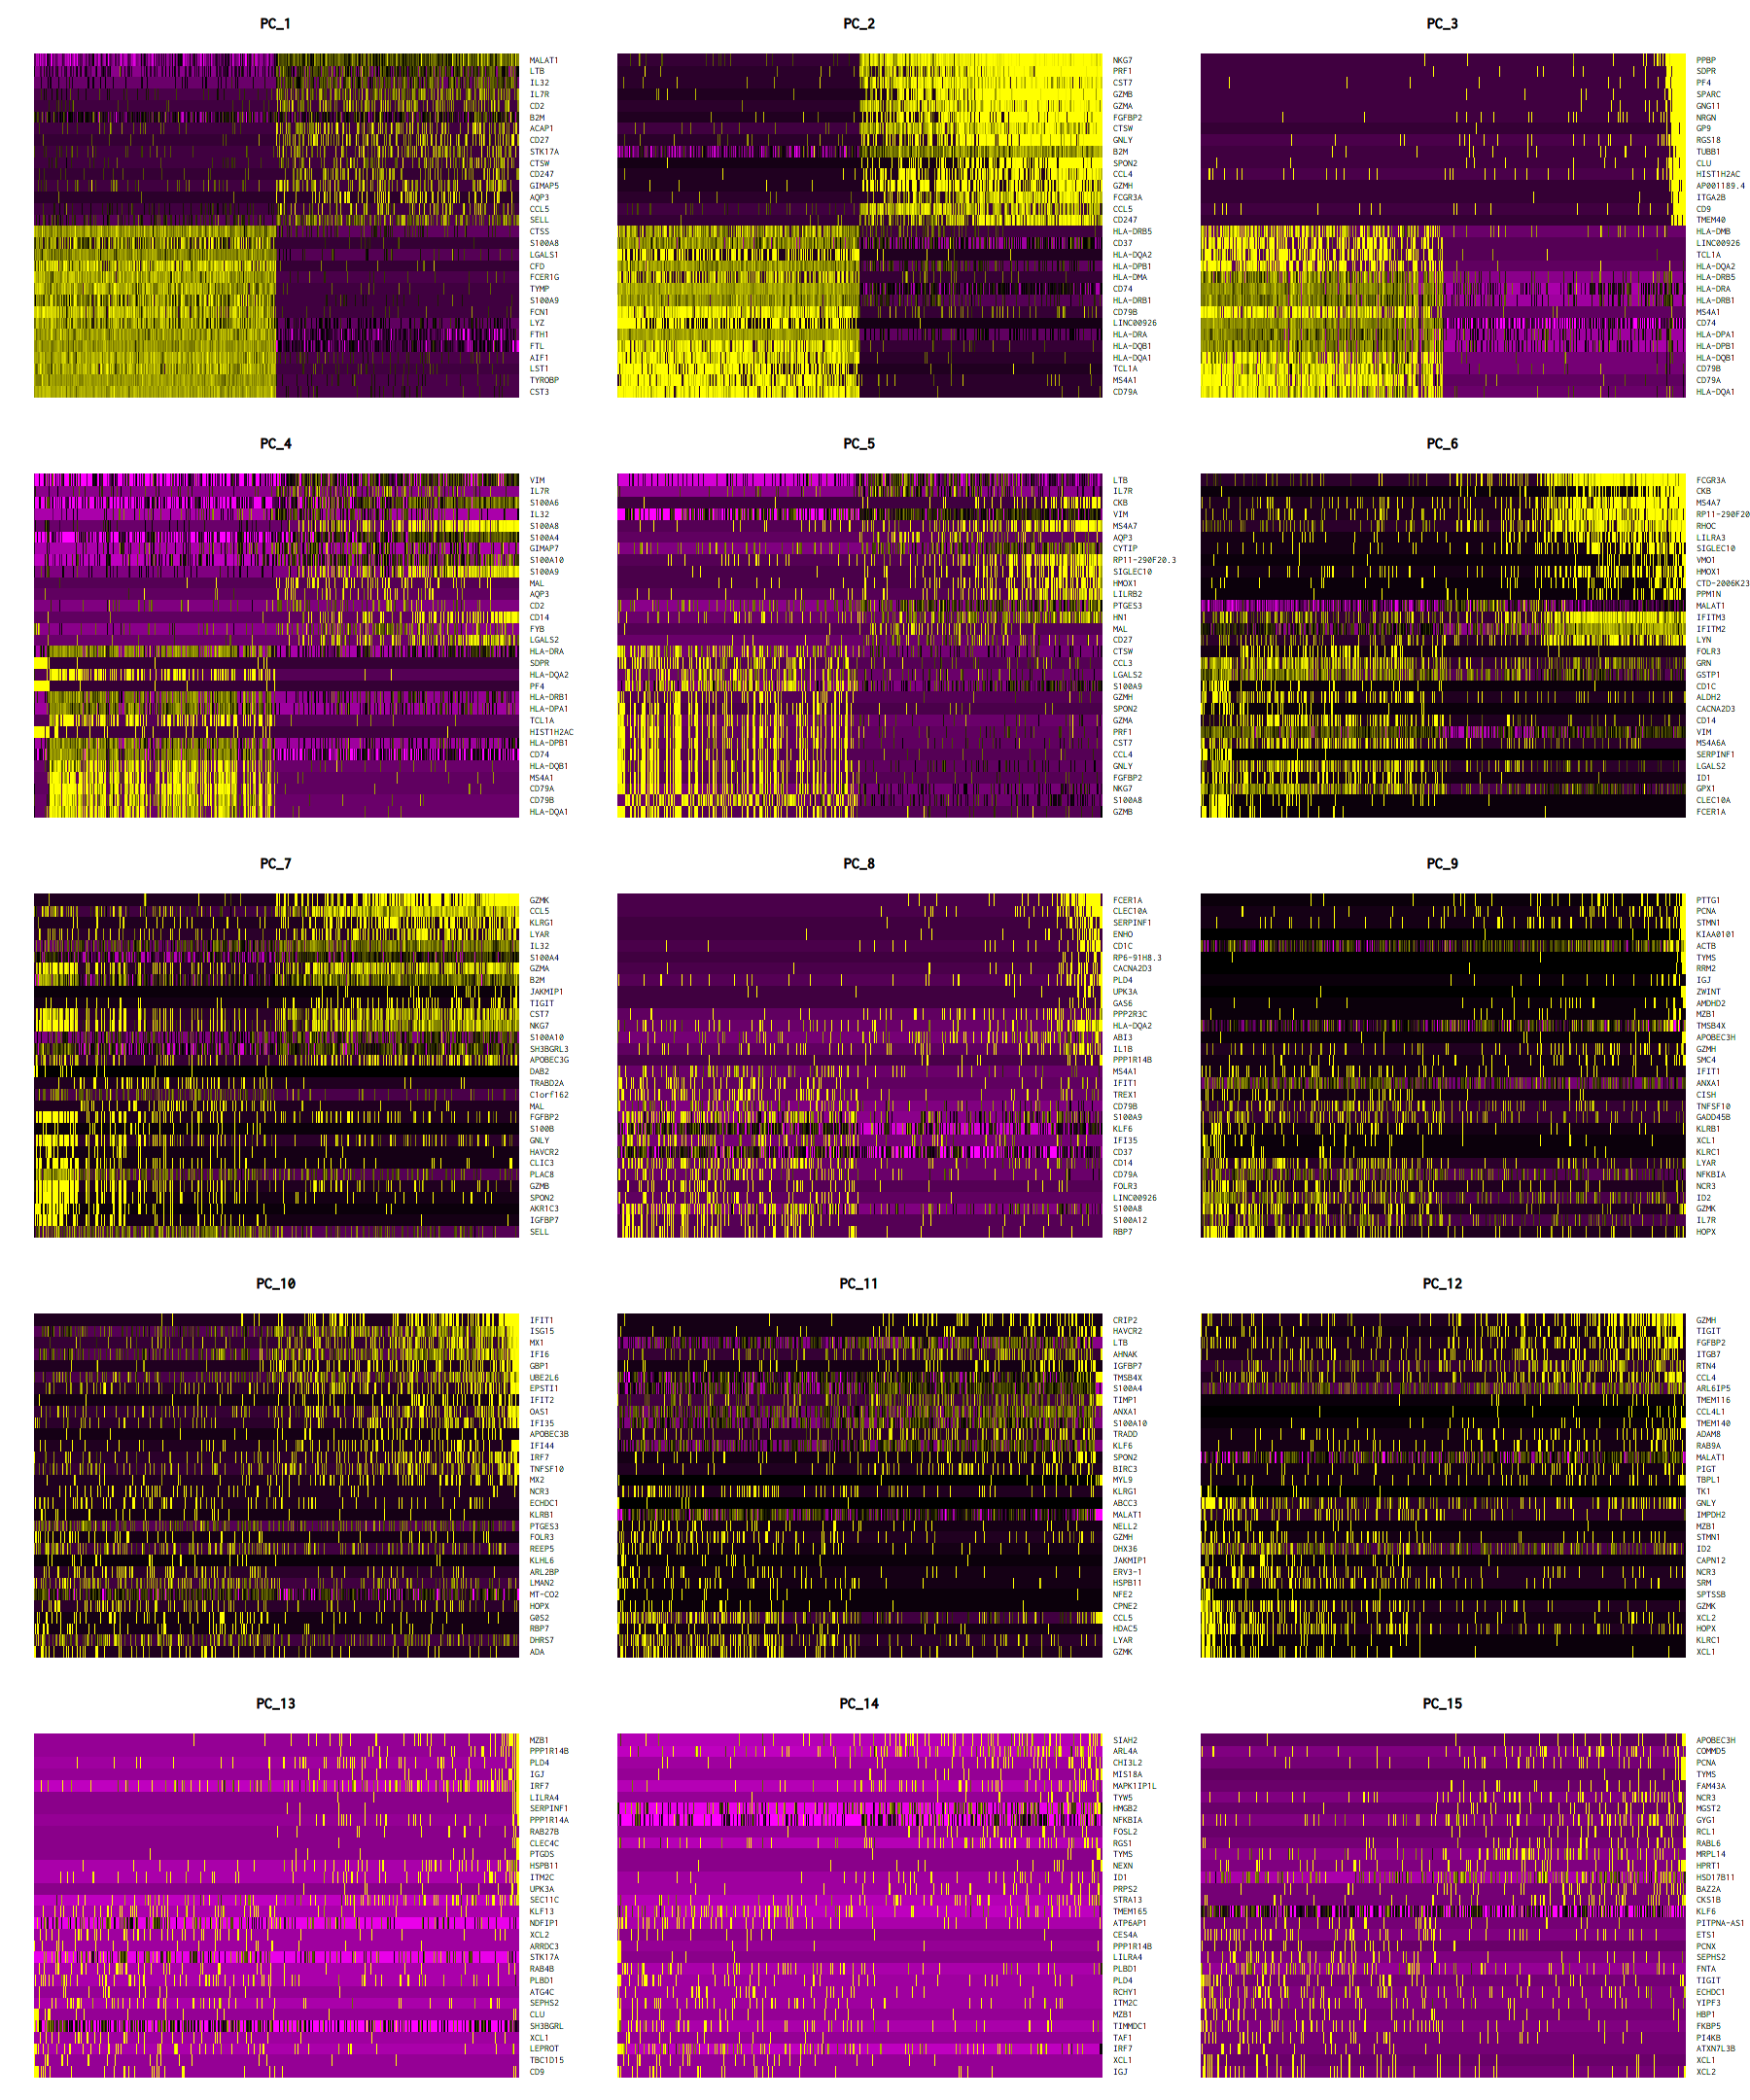

In [19]:
# PC15までを一度に可視化 (目で見る主観的な方法だが有用性が高い)
#（２分されているように見えなければ、その主成分にはもう情報がないと言える）

options(repr.plot.width = 15, repr.plot.height = 18)
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

In [20]:
# Jack-Straw plotによる主成分の可視化
# 黒点線で示されたランダム状態より上に振れているほど情報量が多い
# 実際には主観的であるうえに計算量が非常に多いので個人的にはスキップ推奨
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23504 rows containing missing values (geom_point).”


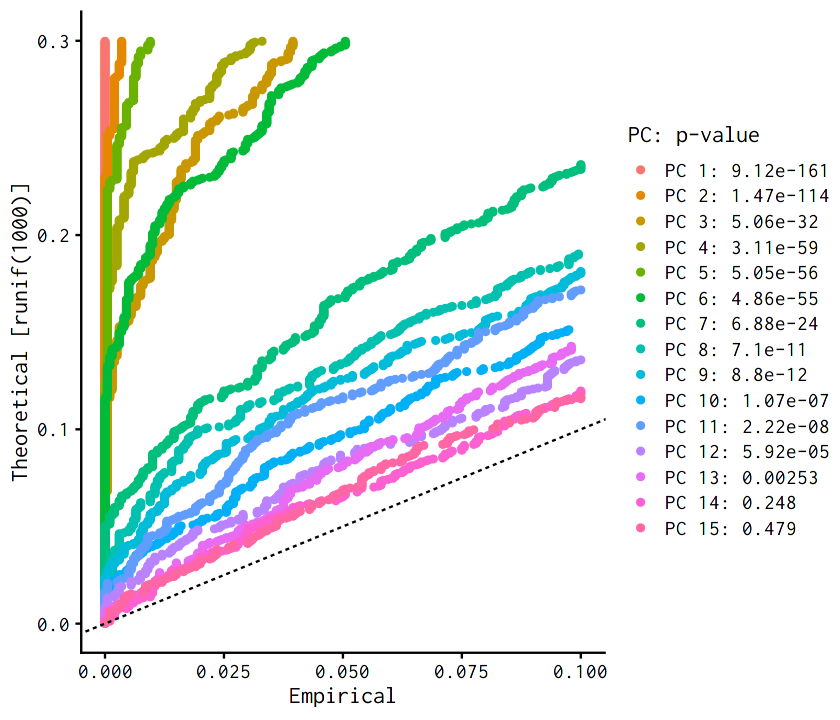

In [21]:
options(repr.plot.width = 7, repr.plot.height = 6)
JackStrawPlot(pbmc, dims = 1:15)

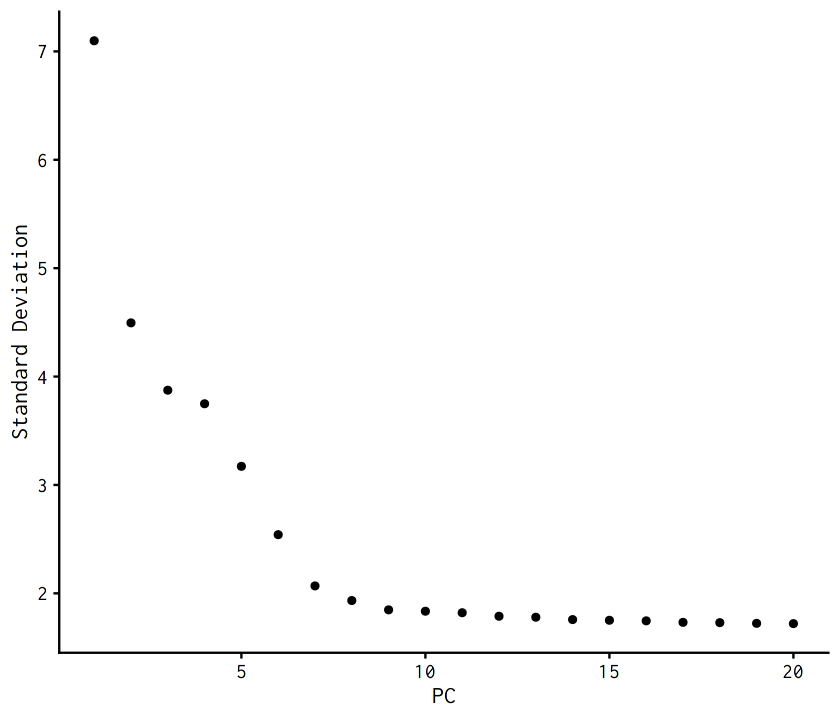

In [22]:
# Elbow plotによる可視化
# 横軸が主成分の次元を表し、降下曲線から水平になる点（Elbow）が最適な主成分の次元数
ElbowPlot(pbmc)

- 異なる数の主成分（10、15、あるいは50！）でダウンストリーム解析を繰り返すと、結果は劇的には変わらないことが多いです。
- 主成分数を選択する際には、なるべく高い方に設定することをお勧めします。例えば、PC5までで下流解析を行うと、結果に重大な悪影響を及ぼします。


## Clustering
- Seurat v3は [PhenoGraph](https://pubmed.ncbi.nlm.nih.gov/26095251/)と同様に graph-based clustering approach を用いてクラスタリングします。 これはK近傍法（KNN）などを用いて近傍に存在する細胞同士をつないでグラフ構造にし、相互に高度に連結した部分細胞群（「準クリーク」または 「コミュニティ」）をクラスタとして抽出する方法です。
- SeuratはPhenoGraphの場合と同様に、まずPCA空間でのユークリッド距離に基づいてK最近傍グラフを作成し、任意の2細胞について、2細胞間の全エッジの重なり（Jaccard類似度）に基づいて２細胞間のエッジの重みを調整します。このステップは`FindNeighbors`関数を使用して実行される。
- （作成者注：従って、クラスタリング結果はtSNE, UMAPどちらを使うかには依存しません。）
- 細胞のクラスタリングにはLouvain algorithm (default) または SLM が用いられます。`FindClusters`関数がこれを行います。クラスタ数を直接指定することはできず、`resolution` を指定することでクラスタ数が変化します（値が大きいほどクラスタの数が多くなる）。
- 我々は、このパラメータを0.4-1.2の間に設定すると、約3000細胞の単細胞データセットで良い結果が得られることを発見しました。最適なresolutionは、より大きなデータセットではしばしば増加します。クラスターは`Idents`関数を使って見つけることができます。得られたクラスタ数は "Number of communities" に表示されます。

In [23]:
# 第10主成分までの値を元にKNNグラフ作成
pbmc <- FindNeighbors(pbmc, dims = 1:10)

# グラフを元にクラスタリング (resolutionを変えるとクラスタ数が変わる)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95858

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8726
Number of communities: 9
Elapsed time: 0 seconds


In [24]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## 次元削減
データセットを可視化するために、tSNEやUMAPのようなツールを用いて次元削減を用います。 低次元空間上で得られたクラスタ内の細胞が近傍同士に配置されるよう、MAPやtSNEの入力として、クラスタリングの入力と同じPCA主成分を使用しなければなりません。

### tSNE

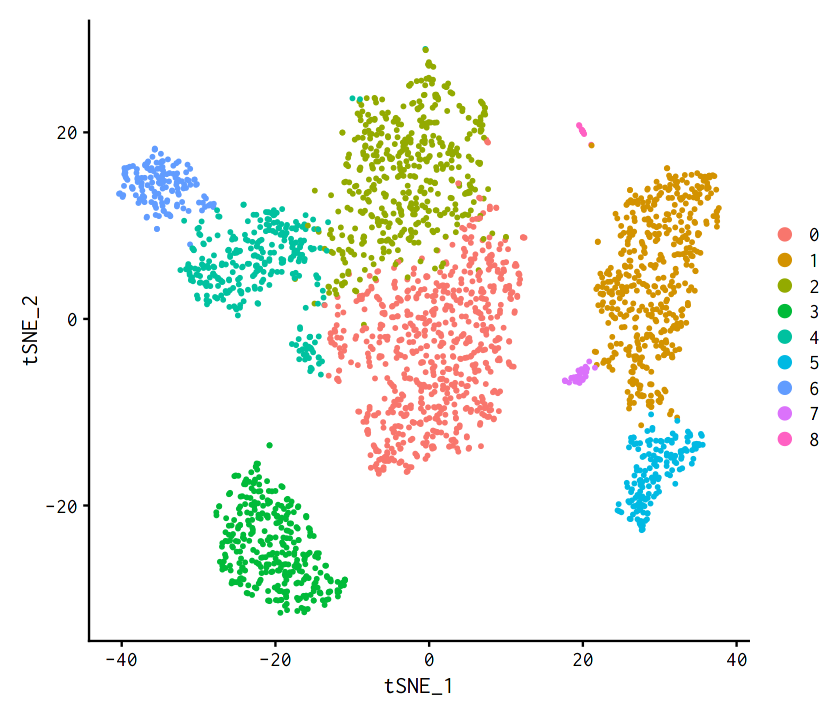

In [25]:
pbmc <- RunTSNE(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "tsne")

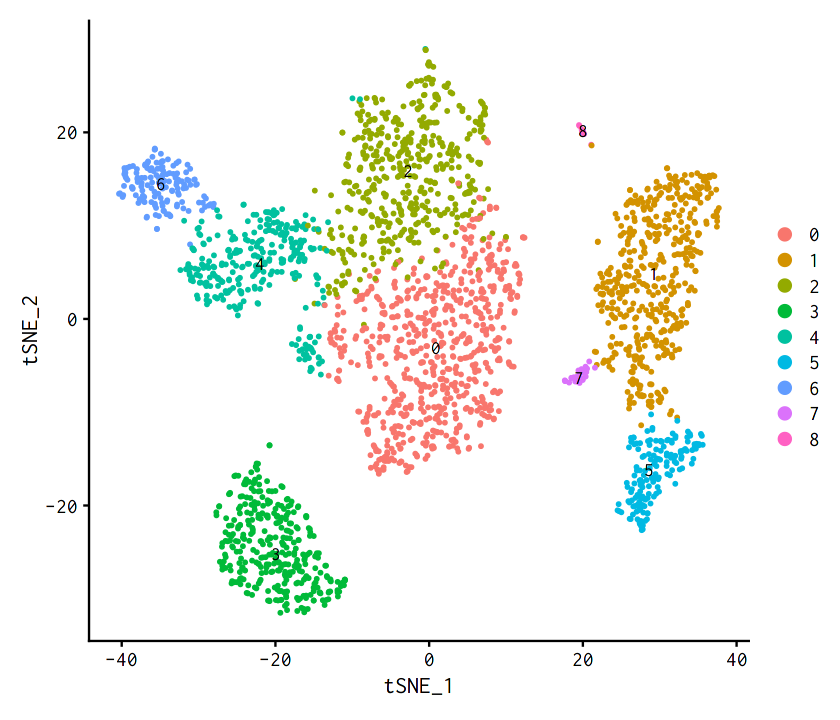

In [26]:
# "label = TRUE" をつけると細胞ラベルありになる
DimPlot(pbmc, reduction = "tsne", label = TRUE)

### UMAP

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:24:28 UMAP embedding parameters a = 0.9922 b = 1.112

20:24:28 Read 2638 rows and found 10 numeric columns

20:24:28 Using Annoy for neighbor search, n_neighbors = 30

20:24:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:24:28 Writing NN index file to temp file /tmp/RtmpdxYGvf/file2d21545610d1

20:24:28 Searching Annoy index using 1 thread, search_k = 3000

20:24:29 Annoy recall = 100%

20:24:29 Commencing smooth kNN distance calibration using 1 thread

20:24:30 Initializing fro

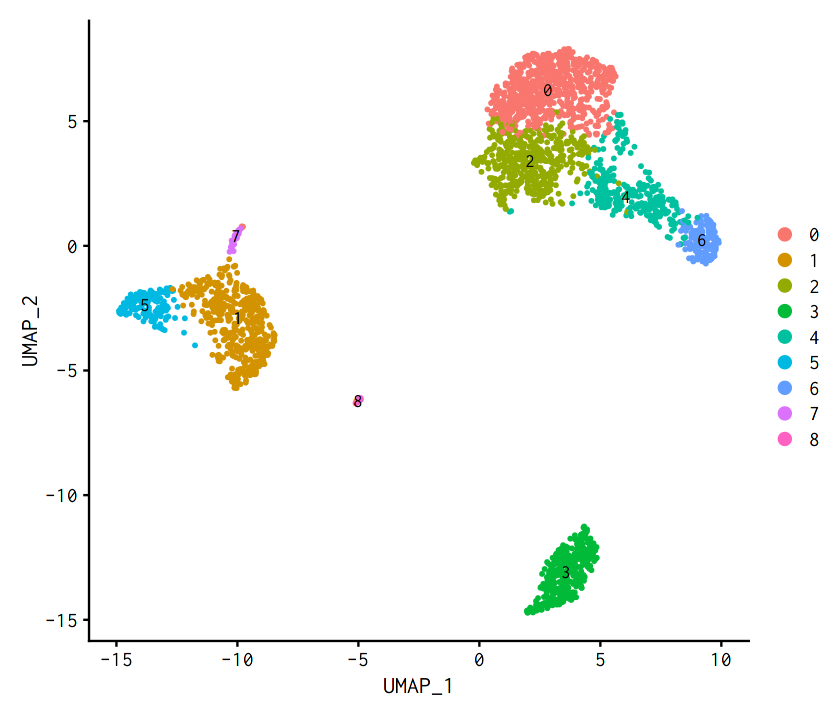

In [27]:
pbmc <- RunUMAP(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "umap", label = TRUE)

### （optional）データ保存
ここまでの作業を毎回繰り返さなくてもよいように、pbmcオブジェクトをファイルとして出力することができます。

In [28]:
# データ保存
saveRDS(pbmc, file = "pbmc_tutorial.rds")

In [29]:
# 保存したデータを後から読み込む場合
# pbmc <- readRDS("pbmc_tutorial.rds")

## Sleepwalkを用いた細胞間発現類似度の可視化
PCAは線形変換のため高次元上での距離がある程度保存されますが、tSNE, UMAPは非線形変換であるため、高次元での相対的な距離やばらつきが保存されません。それを確認するために、Sleepwalkというツールを用いて類似度を可視化したいと思います。

元URL: https://anders-biostat.github.io/sleepwalk/

In [30]:
# ライブラリ読み込み
library(sleepwalk)

In [31]:
pbmc@reductions

$pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 50 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: TRUE 
 Computed using assay: RNA 

$tsne
A dimensional reduction object with key tSNE_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 

$umap
A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 


In [32]:
# 以下のコマンドを実行し、生成された"sleepwalk.html"をブラウザで開いてください。
sleepwalk(list(pbmc@reductions$pca@cell.embeddings[,1:2],
               pbmc@reductions$tsne@cell.embeddings,
               pbmc@reductions$umap@cell.embeddings),
          pbmc@reductions$pca@cell.embeddings,
          saveToFile="sleepwalk.html")

Estimating 'maxdist' for feature matrix 1



得られたhtmlファイルの例は[こちら](./sleepwalk.html)から見ることができます。

## 発現変動解析（クラスタごとのマーカ遺伝子抽出）

得られたクラスタごとに特徴的に発現している遺伝子を同定します。
`min.pct`引数は、比較する2群のいずれかで、この割合以上の細胞数が発現している遺伝子のみを対象とする閾値です。
`thresh.test`引数は、特徴が2つのグループ間で（平均的に）ある程度の差を持って発現していることを要求します。

（作成者注：原理的には特異的に発現が失われている遺伝子も含みますが、実際には高発現遺伝子のみが対象にされることが多いです。）

（作成者注：クラスタは通常３つ以上生成されますが、Seuratでは特定のクラスタと、それ以外の全てのクラスタの２群間比較を行います。その結果、２つのクラスタにまたがって高発現している遺伝子などは抽出されにくくなっていると思われます。）

In [33]:
# クラスタ1に特異的な遺伝子の抽出

cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A9,0.000000e+00,3.860873,0.996,0.215,0.000000e+00
S100A8,0.000000e+00,3.796640,0.975,0.121,0.000000e+00
LGALS2,0.000000e+00,2.634294,0.908,0.059,0.000000e+00
FCN1,0.000000e+00,2.352693,0.952,0.151,0.000000e+00
CD14,2.856582e-294,1.951644,0.667,0.028,3.917516e-290


利用できる発現変動解析法は複数ある。詳細：https://satijalab.org/seurat/v3.2/de_vignette.html

In [36]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

In [35]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,1.219217e-204,2.953683,0.975,0.040,1.672034e-200
CFD,1.757260e-194,2.369997,0.938,0.037,2.409907e-190
IFITM3,2.082108e-194,2.682219,0.975,0.050,2.855402e-190
CD68,4.234603e-191,2.093488,0.926,0.035,5.807335e-187
RP11-290F20.3,3.667846e-186,1.885330,0.840,0.017,5.030084e-182


`FindAllMarkers` を使うと、全クラスタから一度に変動遺伝子を抽出できます。
`only.pos = TRUE` オプションをつけることで、高発現遺伝子のみが出力されます。

In [37]:
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
7.980793e-91,0.9534482,0.452,0.107,1.094486e-86,0,CCR7
5.679448e-32,0.7751959,0.252,0.083,7.788795e-28,0,LDLRAP1
0.000000e+00,3.8608733,0.996,0.215,0.000000e+00,1,S100A9
0.000000e+00,3.7966403,0.975,0.121,0.000000e+00,1,S100A8
1.986662e-87,0.8892711,0.981,0.643,2.724508e-83,2,LTB
4.353526e-61,0.8676191,0.427,0.110,5.970426e-57,2,AQP3
0.000000e+00,2.9875833,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,2.4894932,0.622,0.022,1.300332e-266,3,TCL1A
7.231983e-205,2.1603160,0.980,0.232,9.917942e-201,4,CCL5


### 指定した遺伝子をクラスタごとに分けてviolin plot

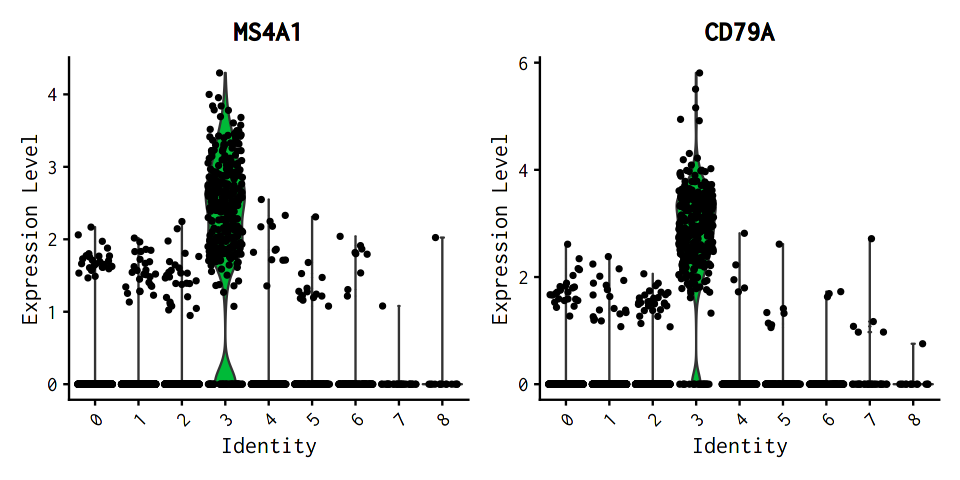

In [42]:
# violin plot (正規化後発現量)
options(repr.plot.width = 8, repr.plot.height = 4)
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

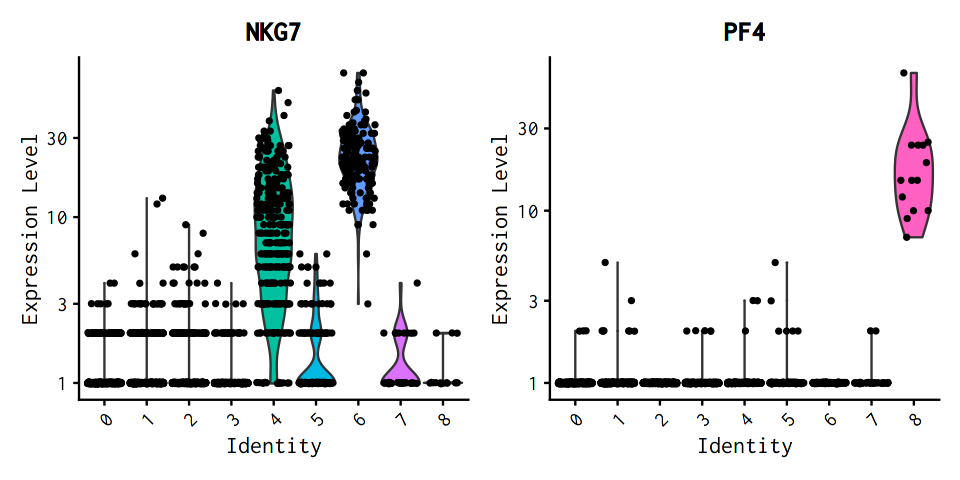

In [43]:
# raw counts (正規化前UMI数)
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

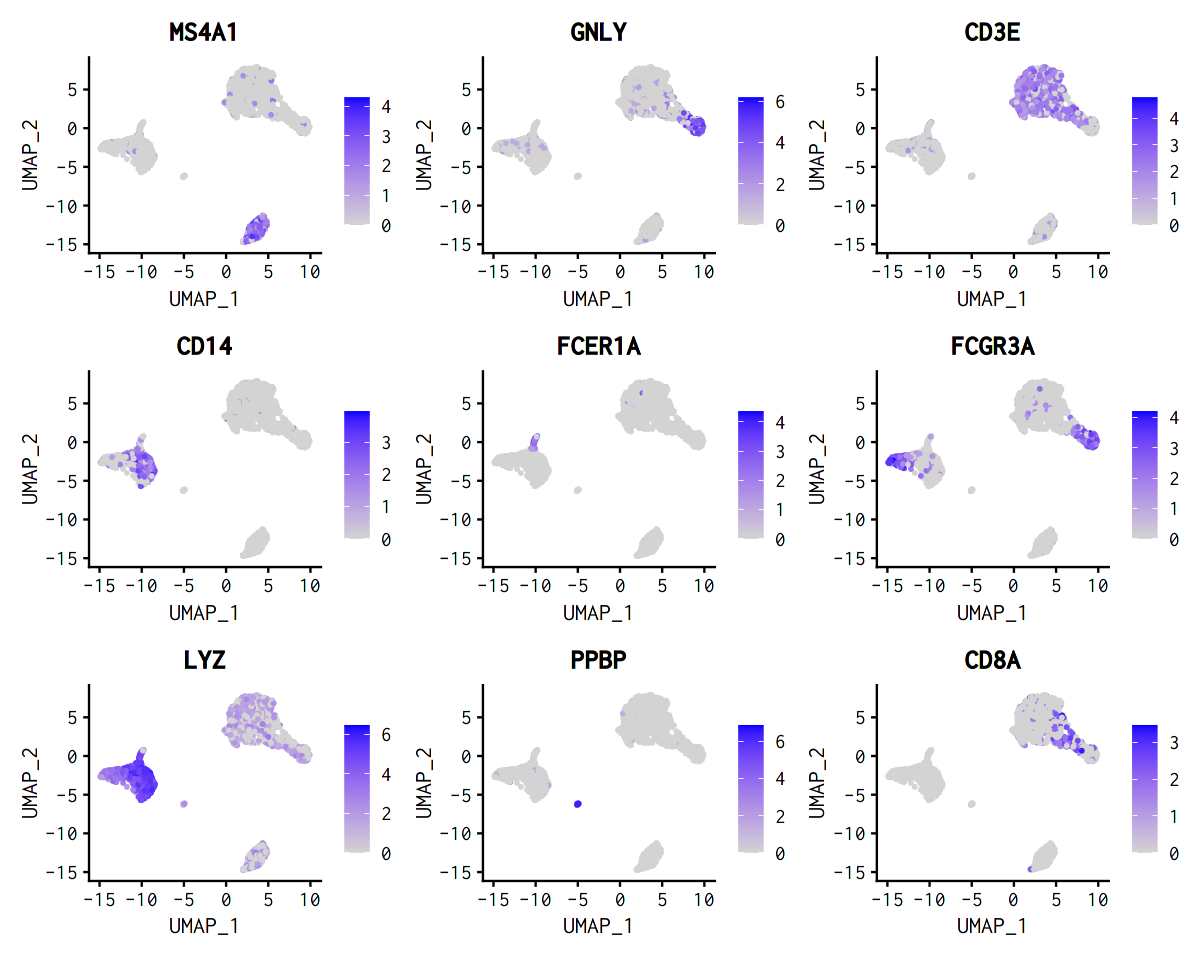

In [45]:
# UMAP (tSNE) プロット上で発現量を可視化
options(repr.plot.width = 10, repr.plot.height = 8)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

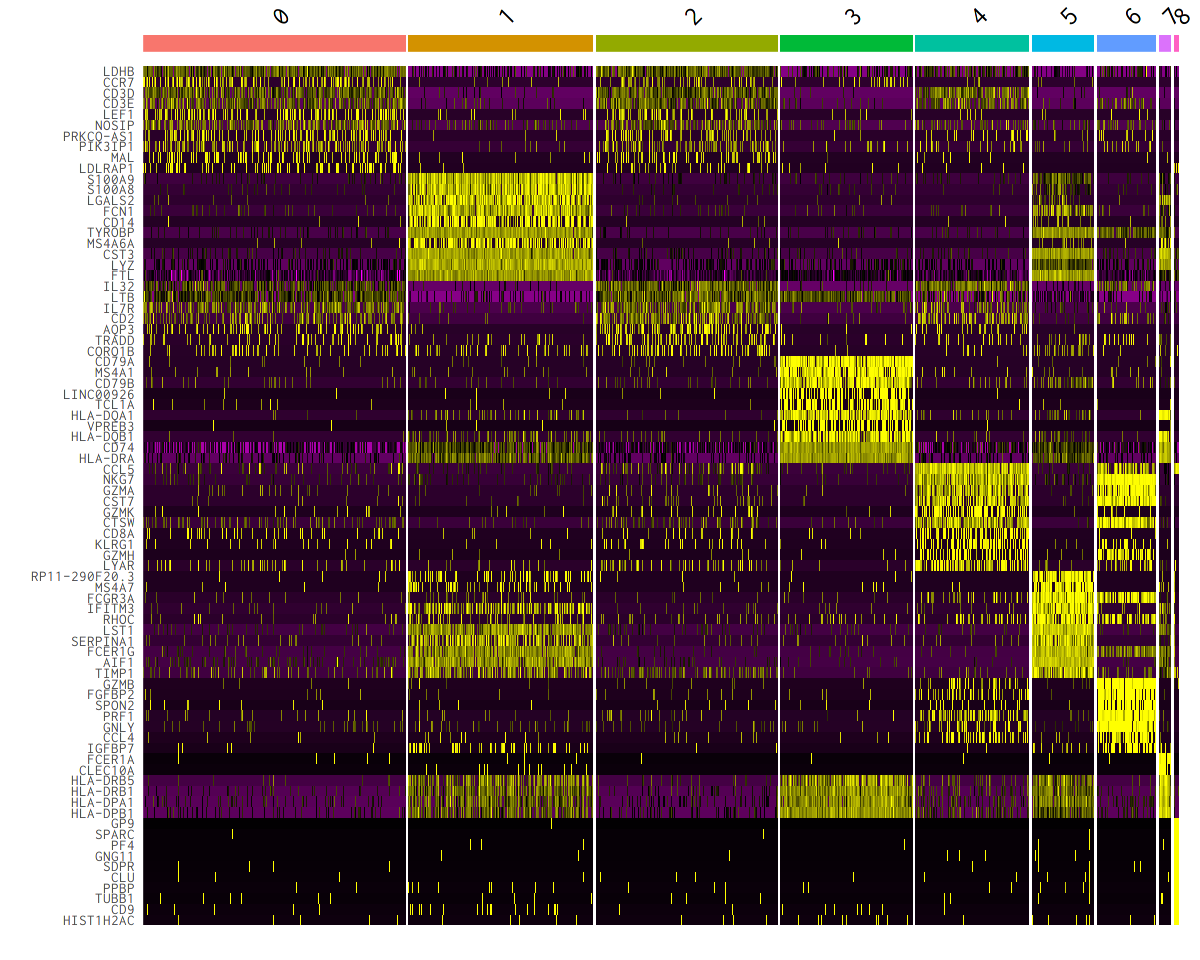

In [46]:
# Heatmap形式での可視化
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

## クラスタのアノテーション (手作業でアノテートする場合)

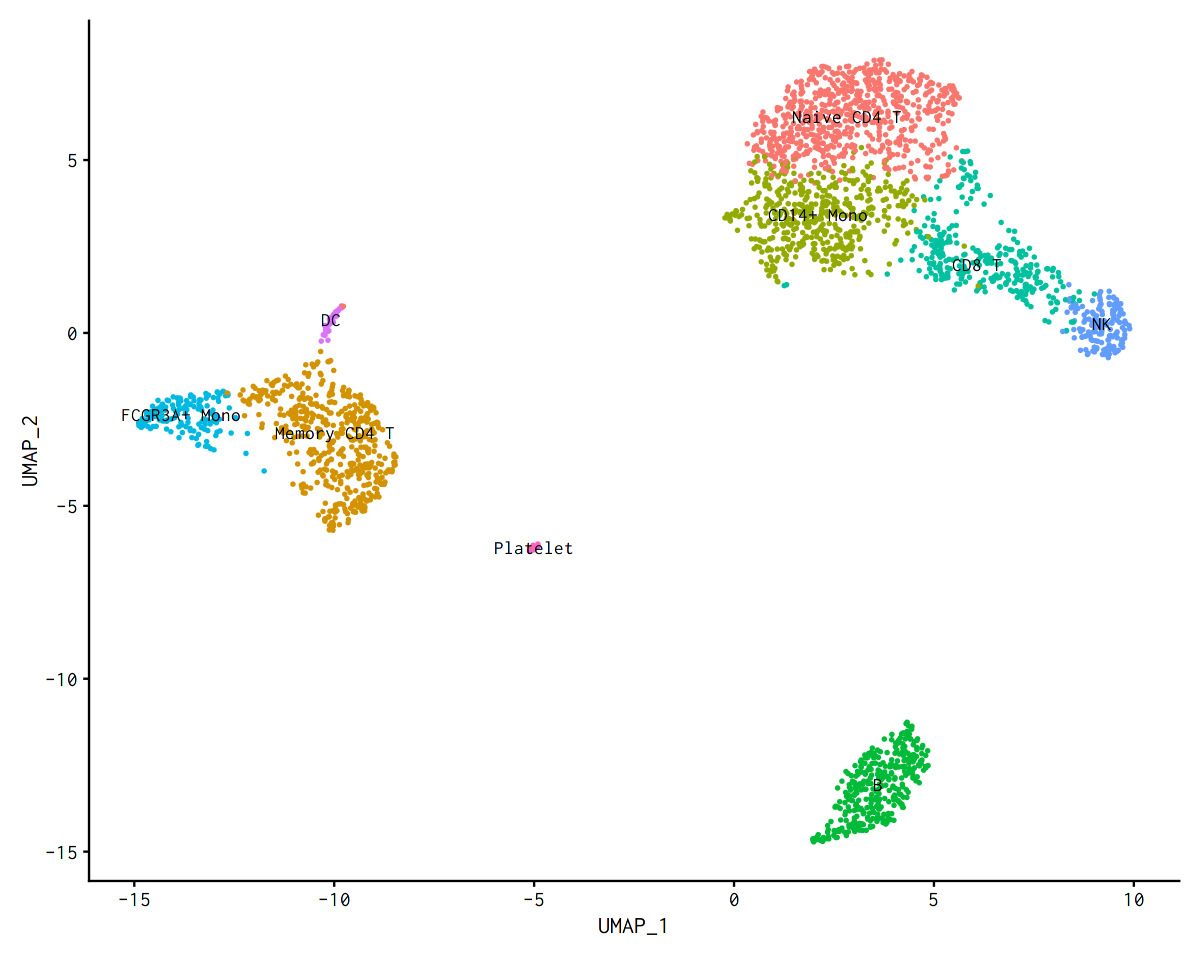

In [47]:
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [48]:
# データ保存
saveRDS(pbmc, file = "pbmc3k_final.rds")